In [149]:
# import statements + data load
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
spotify_dth = pd.read_csv("data/charts.csv")

In [150]:
# basic data cleaning/type conversions
indexes = range(0, len(spotify_dth)) # index
# converting to datetime
spotify_dth['date'] = pd.to_datetime(spotify_dth['date'], format='%Y-%m-%d')

# dropping all rows that did not make the #1 spot
#spotify_dth = [row for index, row in tqdm(spotify_dth.iterrows(), total=len(spotify_dth)) if row['rank'] == 1]
spotify_dth = spotify_dth.drop([index for index, row in spotify_dth.iterrows() if row['rank'] != 1])


# dropping all rows that are not in the US
spotify_dth_US = spotify_dth.drop([index for index, row in spotify_dth.iterrows() if row['region'] != 'United States'])
#spotify_dth_US = [row for index, row in tqdm(spotify_dth.iterrows(), total=len(spotify_dth)) if row['region'] == 'United States']


# resetting indeces of both
spotify_dth.reset_index(inplace=True, drop=True)
spotify_dth_US.reset_index(inplace=True, drop=True)

# saving to csv for reference
spotify_dth.to_csv("data/number_one_all_regions_2017_2021.csv", index=False)
spotify_dth_US.to_csv("data/number_one_US_2017_2021.csv", index=False)
del spotify_dth # removing var to free up memory


In [153]:
# now reading all of the data from the prior project group
years = [2017, 2018, 2019, 2020, 2021]
spotify_dict = {}
for year in years:
    temp_df_name = "spotify_" + str(year) # concatenating df name
    temp_df_directory = "data/" + str(year) + "_complete" + ".csv" # concatenating directory name
    spotify_dict[temp_df_name] = pd.read_csv(temp_df_directory) # adding df to dict
    spotify_dict[temp_df_name].drop(['Unnamed: 0', 'Streams'], axis=1, inplace=True) # dropping index col
    spotify_dict[temp_df_name]["year"] = year # adding identifying year column

# concatenating into a single df
spotify_2017_2021 = pd.concat(spotify_dict.values(), ignore_index=True)
# dropping duplicate songs (if from the same artist)
spotify_2017_2021.drop_duplicates(['Song Names', 'Artists'], keep='first', inplace=True)
spotify_2017_2021.reset_index(inplace=True, drop=True) # resetting index
# renaming song title and artist
spotify_2017_2021.rename(columns={'Song Names': 'title', 'Artists':'artist'}, inplace=True)

# merging in extra features from group's df
spotify_merged = spotify_dth_US.merge(spotify_2017_2021[['title', 'artist', 'Danceability', 'Energy', 'Key', 'Loudness',
                                                    'Mode', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness',
                                                    'Valence', 'Tempo', 'Time Signature', 'year']], on=['title', 'artist'], how='left')

# dropping NA's we acquired (aka drops rows we cannot get extra features for)
spotify_merged.dropna(subset=['Danceability'], inplace=True)
spotify_merged.reset_index(inplace=True, drop=True) # resetting index


In [154]:
# so with 335 NAs in streams, we have two options
# include stream count to also account for streaming amount
# or drop the feature and assume only the genre, danceability, etc. + the covid timeline are what matter...
# let's split it into two dfs and simply try both
spotify_merged_streams_incl = spotify_merged.dropna(subset=['streams'], inplace=False).copy()
spotify_merged_streams_dropped = spotify_merged.drop(['streams'], axis=1, inplace=False).copy()

# resetting index again
spotify_merged_streams_incl.reset_index(inplace=True, drop=True)
spotify_merged_streams_dropped.reset_index(inplace=True, drop=True)

print("length of streams included:",len(spotify_merged_streams_incl),"\nlength of streams dropped:", len(spotify_merged_streams_dropped))


length of streams included: 1257 
length of streams dropped: 1592


In [155]:
# tracking covid period
def map_dates_to_values(date):
    if date < pd.to_datetime('2019-03-01'):
        return 0
    else:
        return 1

# Creating new column based on the dates
spotify_merged_streams_incl.loc[:, 'covid_period'] = spotify_merged_streams_incl['date'].apply(map_dates_to_values)
spotify_merged_streams_dropped.loc[:, 'covid_period'] = spotify_merged_streams_dropped['date'].apply(map_dates_to_values)

In [156]:
# let's go ahead and drop the "title", "rank", "date", "artist", "url", "region", "chart", "trend", "year" for each
# we could come back to this and also try fitting into an nn to get character differences too per song/artist
# as well, we could keep the date as well and try to predict the date or simply group (unsupervised)
spotify_merged_streams_incl.drop(["title", "rank", "date", "artist", "url", "region", "chart", "trend", "year"], axis=1, inplace=True)
spotify_merged_streams_dropped.drop(["title", "rank", "date", "artist", "url", "region", "chart", "trend", "year"], axis=1, inplace=True)

In [157]:
# deleting unneeded dfs
#del spotify_dth_US, spotify_2017_2021, spotify_merged

In [197]:
# alright now it's time to push into the models...
# other imports needed for ML and data cleaning
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier

# we can't use f1, or anything conf matrix metrics due to no probabilities
from sklearn.metrics import f1_score, accuracy_score, classification_report, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import warnings

In [198]:
spotify_merged_streams_incl = pd.read_csv('data/spotify_merged_streams_incl.csv')

In [199]:
# just performing this split on the included streams, you can do the same for dropped

# training and testing splits
# Pull Y variable out which is balance
X = spotify_merged_streams_incl.iloc[:, 0:13].to_numpy()
y = spotify_merged_streams_incl.iloc[:, 13:14].to_numpy().flatten()

# basic T/T/Split modeling due to large size of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)


In [200]:
# debugging...
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((842, 13), (415, 13), (842,), (415,))

In [201]:
# my favorite frankenfunction

def metrics_classification_scorer(y_train, y_test, y_pred, y_proba, show_stats = True, save_f1 = False):
    """

    :param y_test: your testing data
    :param y_pred: your predictions generated from classifier
    :param y_proba: your probabilities generated from classifier
    :param show_stats: default is True, shows ROC Curve, and all other Metrics
    :param save_auc: saves AUC score if desired (must write to variable)
    :return: plots of ROC curve, Conf Matrix Metrics, and AUC Score
    """

    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)
    # y_onehot_test.shape  # (n_samples, n_classes)

    if show_stats:
        RocCurveDisplay.from_predictions(
            y_onehot_test.ravel(),
            y_proba.ravel(),
            name="micro-average OvR",
            color="darkorange",
        )
        plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25))
        plt.show()

    # micro_roc_auc_ovr = roc_auc_score(
    #     y_test,
    #     y_proba,
    #     multi_class="ovr",
    #     average="micro",
    # )

    if show_stats:
        # print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.2f}\n")
        print(f"Test Set Accuracy : {accuracy_score(y_test, y_pred) * 100} %\n")
        print(f"Classification Report : \n\n{classification_report(y_test, y_pred)}")


    # saves auc score if desired
    if save_f1: return f1_score(y_test, y_pred, average='macro')

In [234]:
K = list(range(1,842))
accuracy_scores = []
cv_score = []

for k in K:
    knn = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_prob = knn.predict_proba(X_test)
    knn_accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(knn_accuracy)
    scores = cross_val_score(knn, X, y, cv=25, scoring='accuracy')
    cv_score.append(np.mean(scores))
    print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [235]:
accuracy_scores = np.array(accuracy_scores)
cv_score = np.array(cv_score).astype(float)
K = np.array(K).astype(float)

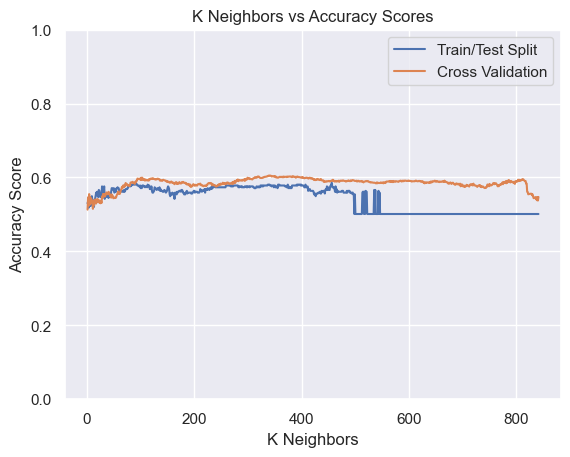

In [237]:
fig, ax = plt.subplots()

# Plot train/test split scores
ax.plot(K, accuracy_scores, label='Train/Test Split')

# Plot cross-validation scores
ax.plot(K, cv_score, label='Cross Validation')

# Add labels and title
ax.set_xlabel('K Neighbors')
ax.set_ylabel('Accuracy Score')
ax.set_title('K Neighbors vs Accuracy Scores')

# Set y-axis limits
ax.set_ylim([0, 1])

# Add legend
ax.legend()

# Display the plot
plt.show()